In [142]:
#getting and working with data
import pandas as pd
import numpy as np
import math
import re
import os

#stats and bioinformatics
from scipy import stats
from scipy import spatial

from statsmodels.stats.multitest import multipletests

import skbio as skbio
from skbio.diversity import alpha_diversity
from skbio.diversity import beta_diversity
from skbio.stats.ordination import pcoa
from skbio.stats.distance import anosim
from skbio.stats.distance import permanova
import networkx as nx

#visualizing results
import matplotlib.pyplot as plt
from matplotlib.patches import Ellipse
import matplotlib.transforms as transforms
%matplotlib inline
import seaborn as sns
sns.set_context('poster', rc={'font.size':35,
                              'axes.titlesize':50,
                              'axes.labelsize':35})

pd.set_option('display.max_rows', 100000)
pd.set_option('display.max_columns', 100000)
pd.set_option('display.width', 100000)

import warnings; warnings.simplefilter('ignore')
np.set_printoptions(suppress=True)

## Paths and mapping

### import data

#### animal meta data

In [143]:
#import path for directory containing files from CoreBiome and corresponding sample/animal key
path_animal = '/Users/abbieschindler/Documents/Schindler_Lab/Data/Microbiome/data/SSS/samples_acute.xlsx'

data_animal_meta = pd.read_excel(path_animal)
data_animal_meta = pd.DataFrame(data = data_animal_meta)
data_animal_meta['animal_code'] = [str(x) for x in data_animal_meta['animal_code']]
print(data_animal_meta.shape)

group_map = {4:'Sham', 5:'Blast'}
data_animal_meta['Group'] = data_animal_meta['Group'].map(group_map)
group_comb_map = {1:'Sham_Female', 2:'Blast_Female', 3:'Sham_Male', 4:'Blast_Male', 7:'Blast_Male_VNS', 8:'Blast_Male_Vehicle', 9:'Blast_Male_norBNI'}
data_animal_meta['Group_comb'] = data_animal_meta['Group_comb'].map(group_comb_map)
data_animal_meta.head()

data_animal_meta.head()

(164, 52)


,Protocol,Round_summary,Round_main,Round_addl,file_name,Animal_#,animal_code,Notes,Cage_#,Group,Group_comb,Sex,feces_tp,feces_fs,Acute_OFB,Sac_TP,Treatment,PSI_1,PSI_2,PSI_3,PSI_ave,ms_1,ms_2,ms_3,ms_ave,imp_1,imp_2,imp_3,imp_ave,LORR_1,LORR_2,LORR_3,LORR_ave,wt_1,wt_2,wt_3,wt_24,wt_48,wt_72,wt_overnight,wt_24.1,wt_48.1,wt_72.1,Fibrinogen,Albumin,Delta,Distance,Mean speed,Center : entries,Center : time,Center : distance,Center : latency
0,Schindler_male,biochemistry,bc_acute_r1,NaN,NaN,876,nan,NaN,SA181,Sham,Sham_Male,m,3,s,2,3.0,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,27.0,27.1,27.2,NaN,27.0,27.5,0.370370,NaN,0.000000,1.851852,NaN,NaN,NaN,33.114,0.110,15.0,29.5,5.356,22.4
1,Schindler_male,biochemistry,bc_acute_r1,NaN,NaN,877,nan,NaN,SA181,Sham,Sham_Male,m,3,s,2,3.0,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,26.2,26.1,26.2,NaN,26.0,26.2,-0.381679,NaN,-0.763359,0.000000,NaN,NaN,NaN,25.224,0.084,21.0,43.2,5.091,19.1
2,Schindler_male,biochemistry,bc_acute_r1,NaN,NaN,878,nan,NaN,SA181,Sham,Sham_Male,m,3,s,2,3.0,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,25.1,24.9,25.5,NaN,25.0,25.6,-0.796813,NaN,-0.398406,1.992032,NaN,NaN,NaN,24.378,0.081,30.0,58.0,6.282,6.1
3,Schindler_male,biochemistry,bc_acute_r1,NaN,NaN,879,nan,NaN,SA182,Sham,Sham_Male,m,3,s,2,3.0,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,28.2,27.9,27.7,NaN,27.8,28.4,-1.063830,NaN,-1.418440,0.709220,NaN,NaN,NaN,15.367,0.051,3.0,3.5,0.539,9.2
4,Schindler_male,biochemistry,bc_acute_r1,NaN,NaN,880,nan,NaN,SA182,Sham,Sham_Male,m,3,s,2,3.0,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,24.5,24.7,24.8,NaN,25.0,25.0,0.816327,NaN,2.040816,2.040816,NaN,NaN,NaN,22.904,0.076,14.0,56.3,5.285,24.1


#### path mapping

In [144]:
#import path for directory containing files from CoreBiome and corresponding sample/animal key
path_mapping = '/Users/abbieschindler/Documents/Schindler_Lab/Data/Microbiome/data/SSS/MB_files_meta.xlsx'

data_path_mapping = pd.read_excel(path_mapping)
data_path_mapping = pd.DataFrame(data = data_path_mapping)
print(data_path_mapping.shape)
data_path_mapping

(15, 4)


,type,path_outer,path_inner,path_filename
0,phylum,/Users/abbieschindler/Documents/Schindler_Lab/...,report/data/filtered-tables/taxatables-by-level,taxatable-phylum-short-relative.tsv
1,class,/Users/abbieschindler/Documents/Schindler_Lab/...,report/data/filtered-tables/taxatables-by-level,taxatable-class-short-relative.tsv
2,order,/Users/abbieschindler/Documents/Schindler_Lab/...,report/data/filtered-tables/taxatables-by-level,taxatable-order-short-relative.tsv
3,family,/Users/abbieschindler/Documents/Schindler_Lab/...,report/data/filtered-tables/taxatables-by-level,taxatable-family-short-relative.tsv
4,genus,/Users/abbieschindler/Documents/Schindler_Lab/...,report/data/filtered-tables/taxatables-by-level,taxatable-genus-short-relative.tsv
5,species,/Users/abbieschindler/Documents/Schindler_Lab/...,report/data/filtered-tables/taxatables-by-level,taxatable-species-short-relative.tsv
6,strain,/Users/abbieschindler/Documents/Schindler_Lab/...,report/data/filtered-tables/taxatables-by-level,taxatable-strain-short-relative.tsv
7,taxa,/Users/abbieschindler/Documents/Schindler_Lab/...,report/data/filtered-tables,taxatable-filtered-relative.tsv
8,otu,/Users/abbieschindler/Documents/Schindler_Lab/...,report/data/filtered-tables,otutable-filtered-relative.tsv
9,enzyme,/Users/abbieschindler/Documents/Schindler_Lab/...,report/data/functional-tables,kotable-enzyme-filtered-relative.tsv


#### file path mapping function

In [145]:
def make_path(ship_name, mapping_type):
    #creates path 
    #ship_index = index of ship_file_names to use (referres to shipping round)
    #mapping_index = type to use for data_path_mapping (referrers to data type)
    data_mapping = data_path_mapping[data_path_mapping['type'] == mapping_type]
    
    path = str(data_mapping['path_outer'].unique()[0] + 
           '/' + ship_name + 
           '/' + data_mapping['path_inner'].unique()[0] + 
           '/' + data_mapping['path_filename'].unique()[0])
    
    return path


In [146]:
#get unique file names (each is a shippment of samples)
ship_file_names = data_animal_meta['file_name'].dropna().unique()
ship_file_names

array(['ship1_VNS4m_24h_72h', 'ship2_VNS72h_norBNI72h_4m',
       'ship3_mf1d_CLAMS272h_etoh'], dtype=object)

## Alpha and beta diversity

### alpha diversity

#### compile animal meta and alpha

In [147]:
#use file name to create path of files
data_alpha = pd.DataFrame()

for ship in ship_file_names:
    print(ship)
    
    path = make_path(ship, 'alpha')
    print(path)
    
    data_int = pd.read_table(path)
    data_int = pd.DataFrame(data = data_int)
    data_int.columns = ['animal_code', 'observed', 'chao1', 'shannon']
    data_int['file_name'] = ship
    print(data_int.shape)
    
    if data_alpha.shape[0] == 0:
        data_alpha = data_int
    else:
        data_alpha = pd.concat([data_alpha, data_int])
    
    print(data_alpha.shape)

data_alpha['animal_code'] = [str(x) for x in data_alpha['animal_code']]
print(data_alpha.shape)
data_alpha.head()


ship1_VNS4m_24h_72h
/Users/abbieschindler/Documents/Schindler_Lab/Data/Microbiome/data/SSS/ship1_VNS4m_24h_72h/report/data/alphadiversity/alphadiversity.txt
(35, 5)
(35, 5)
ship2_VNS72h_norBNI72h_4m
/Users/abbieschindler/Documents/Schindler_Lab/Data/Microbiome/data/SSS/ship2_VNS72h_norBNI72h_4m/report/data/alphadiversity/alphadiversity.txt
(57, 5)
(92, 5)
ship3_mf1d_CLAMS272h_etoh
/Users/abbieschindler/Documents/Schindler_Lab/Data/Microbiome/data/SSS/ship3_mf1d_CLAMS272h_etoh/report/data/alphadiversity/alphadiversity.txt
(49, 5)
(141, 5)
(141, 5)


,animal_code,observed,chao1,shannon,file_name
0,895.S,112.0,162.214286,3.383946,ship1_VNS4m_24h_72h
1,896.S,125.0,158.000000,3.587183,ship1_VNS4m_24h_72h
2,897.S,120.0,147.352941,3.758469,ship1_VNS4m_24h_72h
3,898.S,101.0,148.571429,2.147103,ship1_VNS4m_24h_72h
4,899.S,137.0,182.555556,3.482640,ship1_VNS4m_24h_72h


In [148]:
#combine with meta data
data_alpha_final = data_animal_meta.merge(data_alpha, 
                                          on=['animal_code', 'file_name'])

print(data_alpha_final.shape)
data_alpha_final.head()

(100, 55)


,Protocol,Round_summary,Round_main,Round_addl,file_name,Animal_#,animal_code,Notes,Cage_#,Group,Group_comb,Sex,feces_tp,feces_fs,Acute_OFB,Sac_TP,Treatment,PSI_1,PSI_2,PSI_3,PSI_ave,ms_1,ms_2,ms_3,ms_ave,imp_1,imp_2,imp_3,imp_ave,LORR_1,LORR_2,LORR_3,LORR_ave,wt_1,wt_2,wt_3,wt_24,wt_48,wt_72,wt_overnight,wt_24.1,wt_48.1,wt_72.1,Fibrinogen,Albumin,Delta,Distance,Mean speed,Center : entries,Center : time,Center : distance,Center : latency,observed,chao1,shannon
0,Schindler_male,biochemistry,bc_acute_r2,NaN,ship1_VNS4m_24h_72h,895,895.S,NaN,SA187,Sham,Sham_Male,m,1,s,n,1.0,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,32.0,32.1,32.5,31.8,NaN,NaN,0.312500,-0.625000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,112.0,162.214286,3.383946
1,Schindler_male,biochemistry,bc_acute_r2,NaN,ship1_VNS4m_24h_72h,896,896.S,NaN,SA187,Sham,Sham_Male,m,1,s,n,1.0,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,29.9,29.7,30.0,29.8,NaN,NaN,-0.668896,-0.334448,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,125.0,158.000000,3.587183
2,Schindler_male,biochemistry,bc_acute_r2,NaN,ship1_VNS4m_24h_72h,897,897.S,NaN,SA187,Sham,Sham_Male,m,1,s,n,1.0,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,28.8,28.8,29.0,29.1,NaN,NaN,0.000000,1.041667,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,120.0,147.352941,3.758469
3,Schindler_male,biochemistry,bc_acute_r2,NaN,ship1_VNS4m_24h_72h,898,898.S,NaN,SA188,Sham,Sham_Male,m,3,s,n,3.0,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,32.5,32.5,32.8,NaN,NaN,32.8,0.000000,NaN,NaN,0.923077,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,101.0,148.571429,2.147103
4,Schindler_male,biochemistry,bc_acute_r2,NaN,ship1_VNS4m_24h_72h,899,899.S,NaN,SA188,Sham,Sham_Male,m,3,s,n,3.0,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,30.5,30.2,30.4,NaN,NaN,29.6,-0.983607,NaN,NaN,-2.950820,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,137.0,182.555556,3.482640


In [149]:
data_alpha = data_alpha_final[data_alpha_final['Round_main'] == 'bc_BBB_r1']
#data_tp = data_alpha_final[data_alpha_final['feces_tp'] == 1]
print(data_alpha.shape)

(21, 55)


observed


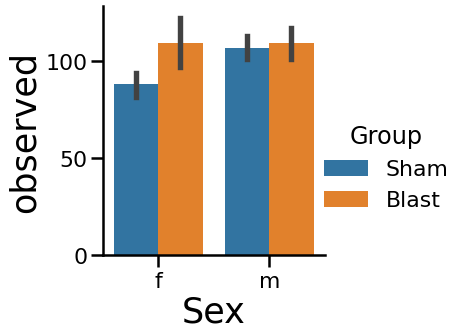



KruskalResult(statistic=4.072878312035246, pvalue=0.25370136211951494)


shannon


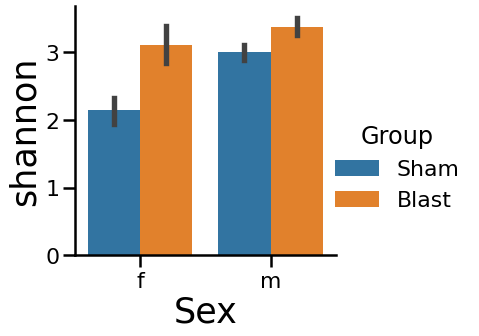



KruskalResult(statistic=14.58295454545456, pvalue=0.002210060753434878)


chao1


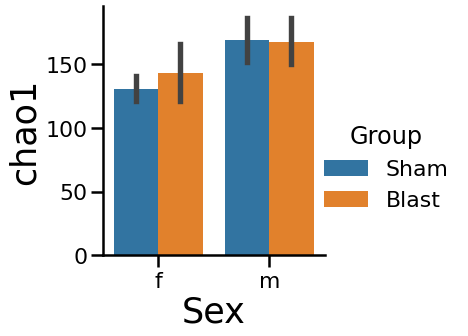



KruskalResult(statistic=2.9248737373737557, pvalue=0.4033537929956129)




In [150]:

#viz abundance params and compute significance
viz_params = ['observed', 'shannon', 'chao1']

for param in viz_params:
    try:
        print(param)

        g = sns.catplot(x='Sex', y=param, data=data_alpha, kind='bar', height=5, aspect=1, hue='Group', ci=68)
        plt.show()
        print('\n')
        
        x = data_alpha[data_alpha['Group'] == 'Sham'][param]
        y = data_alpha[data_alpha['Group'] == 'Blast'][param]
        z = data_alpha[data_alpha['Sex'] == 'm'][param]
        a = data_alpha[data_alpha['Sex'] == 'f'][param]
        #z = OTU_data_diversity[OTU_data_diversity['group'] == 7][param]
        print(stats.kruskal(x,y,z,a))
        print('\n')
        
    except:
        pass

### beta diversity

#### compile animal meta and filtered otu table 

In [151]:
#use file name to create path of files
data_otu = pd.DataFrame()

for ship in ship_file_names:
    print(ship)
    
    path = make_path(ship, 'otu')
    print(path)
    
    data_int = pd.read_table(path)
    data_int = pd.DataFrame(data = data_int).set_index('@otu').T.reset_index()
    
    data_int.rename(columns={"index": 'animal_code'}, inplace=True)
    data_int['animal_code'] = [str(x) for x in data_int['animal_code']]
    data_int['file_name'] = ship
    print(data_int.shape)
    
    if data_otu.shape[0] == 0:
        data_otu = data_int
    else:
        data_otu = pd.concat([data_otu, data_int])
    
    print(data_otu.shape)

#data_otu.replace({np.nan: 0}, inplace=True)    
print(data_otu.shape)
data_otu.tail()


ship1_VNS4m_24h_72h
/Users/abbieschindler/Documents/Schindler_Lab/Data/Microbiome/data/SSS/ship1_VNS4m_24h_72h/report/data/filtered-tables/otutable-filtered-relative.tsv
(35, 364)
(35, 364)
ship2_VNS72h_norBNI72h_4m
/Users/abbieschindler/Documents/Schindler_Lab/Data/Microbiome/data/SSS/ship2_VNS72h_norBNI72h_4m/report/data/filtered-tables/otutable-filtered-relative.tsv
(58, 371)
(93, 400)
ship3_mf1d_CLAMS272h_etoh
/Users/abbieschindler/Documents/Schindler_Lab/Data/Microbiome/data/SSS/ship3_mf1d_CLAMS272h_etoh/report/data/filtered-tables/otutable-filtered-relative.tsv
(49, 413)
(142, 464)
(142, 464)


,animal_code,GCF_001945605.1,GCF_000008065.1,GCF_000007785.1,GCF_001055755.1,GCF_000205025.1,GCF_000144975.1,GCF_000020225.1,GCF_000009925.1,GCF_000011065.1,GCF_000012825.1,GCF_000014425.1,GCF_000020605.1,GCF_000091405.1,GCF_000162275.1,GCF_000159355.1,GCF_000157075.2,GCF_000153885.1,GCF_000156195.1,GCF_000154425.1,GCF_000154385.1,GCF_000154285.1,GCF_000154205.1,GCF_000153905.1,GCF_000154105.1,GCF_000156035.2,GCF_000154565.1,GCF_000154465.1,GCF_000154505.1,GCF_000154825.1,GCF_000155875.1,GCF_000156015.1,GCF_000156535.1,GCF_000156495.1,GCF_000157055.1,GCF_000157035.2,GCF_000158655.1,GCF_000158075.1,GCF_000157995.1,GCF_000157975.1,GCF_000157955.1,GCF_000159055.1,GCF_000162135.1,GCF_000160095.1,GCF_000162015.1,GCF_000162195.1,GCF_000178255.1,GCF_000163675.1,GCF_000163655.1,GCF_000162555.1,GCF_000163515.2,GCF_000177015.3,GCF_000174195.1,GCF_000169235.1,GCF_000169255.2,GCF_000173975.1,GCF_000177035.2,GCF_000204985.1,GCF_000189615.1,GCF_000189595.1,GCF_000186525.1,GCF_000190355.1,GCF_000191545.1,GCF_000194115.1,GCF_000364245.1,GCF_000307345.1,GCF_000273215.1,GCF_000233515.1,GCF_000225745.1,GCF_000205165.1,GCF_000210575.1,GCF_000225345.1,GCF_000225685.1,GCF_000239295.1,GCF_000235445.1,GCF_000234155.1,GCF_000235885.1,GCF_000235505.1,GCF_000238635.1,GCF_000242175.1,GCF_000242955.1,GCF_000242195.1,GCF_000244855.1,GCF_000265365.1,GCF_000260715.1,GCF_000273075.1,GCF_000273195.1,GCF_000273315.1,GCF_000273295.1,GCF_000273725.1,GCF_000281195.1,GCF_000304195.1,GCF_000364225.1,GCF_000364185.1,GCF_000364165.1,GCF_000312145.1,GCF_000307395.1,GCF_000307375.1,GCF_000311925.1,GCF_000320405.1,GCF_000317915.1,GCF_000403195.1,GCF_000403175.1,GCF_000374505.1,GCF_000371525.1,GCF_000371485.1,GCF_000371425.1,GCF_000371505.1,GCF_000371545.1,GCF_000371645.1,GCF_000371685.1,GCF_000403155.2,GCF_000498675.1,GCF_000403415.2,GCF_000403235.1,GCF_000403395.2,GCF_000403355.2,GCF_000403435.2,GCF_000403455.2,GCF_000422625.1,GCF_000403845.2,GCF_000403825.2,GCF_000411355.1,GCF_000411335.1,GCF_000413395.1,GCF_000478885.1,GCF_000471945.1,GCF_000466445.2,GCF_000424325.1,GCF_000424225.1,GCF_000427365.1,GCF_000424345.1,GCF_000439275.1,GCF_000469345.1,GCF_000466565.1,GCF_000466485.1,GCF_000492175.1,GCF_000484655.1,GCF_000800475.2,GCF_000741575.1,GCF_000709415.1,GCF_000526735.1,GCF_000507805.1,GCF_000507785.1,GCF_000512915.1,GCF_000702025.1,GCF_000701665.1,GCF_000723745.2,GCF_000741135.1,GCF_000742975.1,GCF_000765135.1,GCF_000760655.1,GCF_000765245.1,GCF_000821285.2,GCF_000953575.1,GCF_000969835.1,GCF_001816245.2,GCF_001543345.1,GCF_001405255.1,GCF_001405095.1,GCF_001314975.1,GCF_001244545.1,GCF_001063505.1,GCF_001078435.1,GCF_001073155.1,GCF_001244495.1,GCF_001185345.1,GCF_001280875.1,GCF_001244995.1,GCF_001281305.1,GCF_001312505.1,GCF_001311035.1,GCF_001404335.1,GCF_001318345.1,GCF_001318405.1,GCF_001404555.1,GCF_001404375.1,GCF_001404495.1,GCF_001404475.1,GCF_001404435.1,GCF_001405075.1,GCF_001404755.1,GCF_001404635.1,GCF_001404595.1,GCF_001404735.1,GCF_001405015.1,GCF_001404815.1,GCF_001405115.1,GCF_001405155.1,GCF_001405175.1,GCF_001405215.1,GCF_001405235.1,GCF_001406535.1,GCF_001405895.1,GCF_001405595.1,GCF_001405335.1,GCF_001405315.1,GCF_001405515.1,GCF_001405455.1,GCF_001405415.1,GCF_001405555.1,GCF_001405535.1,GCF_001405675.1,GCF_001405615.1,GCF_001405655.1,GCF_001405855.1,GCF_001406335.1,GCF_001406075.1,GCF_001406015.1,GCF_001405975.1,GCF_001405955.1,GCF_001405995.1,GCF_001406055.1,GCF_001406135.1,GCF_001406295.1,GCF_001406255.1,GCF_001406175.1,GCF_001406435.1,GCF_001406395.1,GCF_001406375.1,GCF_001406675.1,GCF_001406635.1,GCF_001406615.1,GCF_001406595.1,GCF_001406755.1,GCF_001406695.1,GCF_001406715.1,GCF_001435325.1,GCF_001434435.1,GCF_001486665.1,GCF_001436695.1,GCF_001436575.1,GCF_001436315.1,GCF_001461035.1,GCF_001454945.1,GCF_001487165.1,GCF_001486905.1,GCF_001535605.1,GCF_001517625.2,GCF_001535615.1,GCF_001688765.2,GCF_001688705.2,GCF_001578565.1,GCF_001546525.1,GCF_001688665.2,GCF_001578575.1,GCF_001641065.1,GCF_001688625.2,GCF_001688645.2,GCF_001688725.2,GCF

In [152]:
#combine with meta data
data_otu_final = data_animal_meta.merge(data_otu, 
                                          on=['animal_code', 'file_name'])

print(data_otu_final.shape)
data_otu_final.head()

(101, 514)


,Protocol,Round_summary,Round_main,Round_addl,file_name,Animal_#,animal_code,Notes,Cage_#,Group,Group_comb,Sex,feces_tp,feces_fs,Acute_OFB,Sac_TP,Treatment,PSI_1,PSI_2,PSI_3,PSI_ave,ms_1,ms_2,ms_3,ms_ave,imp_1,imp_2,imp_3,imp_ave,LORR_1,LORR_2,LORR_3,LORR_ave,wt_1,wt_2,wt_3,wt_24,wt_48,wt_72,wt_overnight,wt_24.1,wt_48.1,wt_72.1,Fibrinogen,Albumin,Delta,Distance,Mean speed,Center : entries,Center : time,Center : distance,Center : latency,GCF_001945605.1,GCF_000008065.1,GCF_000007785.1,GCF_001055755.1,GCF_000205025.1,GCF_000144975.1,GCF_000020225.1,GCF_000009925.1,GCF_000011065.1,GCF_000012825.1,GCF_000014425.1,GCF_000020605.1,GCF_000091405.1,GCF_000162275.1,GCF_000159355.1,GCF_000157075.2,GCF_000153885.1,GCF_000156195.1,GCF_000154425.1,GCF_000154385.1,GCF_000154285.1,GCF_000154205.1,GCF_000153905.1,GCF_000154105.1,GCF_000156035.2,GCF_000154565.1,GCF_000154465.1,GCF_000154505.1,GCF_000154825.1,GCF_000155875.1,GCF_000156015.1,GCF_000156535.1,GCF_000156495.1,GCF_000157055.1,GCF_000157035.2,GCF_000158655.1,GCF_000158075.1,GCF_000157995.1,GCF_000157975.1,GCF_000157955.1,GCF_000159055.1,GCF_000162135.1,GCF_000160095.1,GCF_000162015.1,GCF_000162195.1,GCF_000178255.1,GCF_000163675.1,GCF_000163655.1,GCF_000162555.1,GCF_000163515.2,GCF_000177015.3,GCF_000174195.1,GCF_000169235.1,GCF_000169255.2,GCF_000173975.1,GCF_000177035.2,GCF_000204985.1,GCF_000189615.1,GCF_000189595.1,GCF_000186525.1,GCF_000190355.1,GCF_000191545.1,GCF_000194115.1,GCF_000364245.1,GCF_000307345.1,GCF_000273215.1,GCF_000233515.1,GCF_000225745.1,GCF_000205165.1,GCF_000210575.1,GCF_000225345.1,GCF_000225685.1,GCF_000239295.1,GCF_000235445.1,GCF_000234155.1,GCF_000235885.1,GCF_000235505.1,GCF_000238635.1,GCF_000242175.1,GCF_000242955.1,GCF_000242195.1,GCF_000244855.1,GCF_000265365.1,GCF_000260715.1,GCF_000273075.1,GCF_000273195.1,GCF_000273315.1,GCF_000273295.1,GCF_000273725.1,GCF_000281195.1,GCF_000304195.1,GCF_000364225.1,GCF_000364185.1,GCF_000364165.1,GCF_000312145.1,GCF_000307395.1,GCF_000307375.1,GCF_000311925.1,GCF_000320405.1,GCF_000317915.1,GCF_000403195.1,GCF_000403175.1,GCF_000374505.1,GCF_000371525.1,GCF_000371485.1,GCF_000371425.1,GCF_000371505.1,GCF_000371545.1,GCF_000371645.1,GCF_000371685.1,GCF_000403155.2,GCF_000498675.1,GCF_000403415.2,GCF_000403235.1,GCF_000403395.2,GCF_000403355.2,GCF_000403435.2,GCF_000403455.2,GCF_000422625.1,GCF_000403845.2,GCF_000403825.2,GCF_000411355.1,GCF_000411335.1,GCF_000413395.1,GCF_000478885.1,GCF_000471945.1,GCF_000466445.2,GCF_000424325.1,GCF_000424225.1,GCF_000427365.1,GCF_000424345.1,GCF_000439275.1,GCF_000469345.1,GCF_000466565.1,GCF_000466485.1,GCF_000492175.1,GCF_000484655.1,GCF_000800475.2,GCF_000741575.1,GCF_000709415.1,GCF_000526735.1,GCF_000507805.1,GCF_000507785.1,GCF_000512915.1,GCF_000702025.1,GCF_000701665.1,GCF_000723745.2,GCF_000741135.1,GCF_000742975.1,GCF_000765135.1,GCF_000760655.1,GCF_000765245.1,GCF_000821285.2,GCF_000953575.1,GCF_000969835.1,GCF_001816245.2,GCF_001543345.1,GCF_001405255.1,GCF_001405095.1,GCF_001314975.1,GCF_001244545.1,GCF_001063505.1,GCF_001078435.1,GCF_001073155.1,GCF_001244495.1,GCF_001185345.1,GCF_001280875.1,GCF_001244995.1,GCF_001281305.1,GCF_001312505.1,GCF_001311035.1,GCF_001404335.1,GCF_001318345.1,GCF_001318405.1,GCF_001404555.1,GCF_001404375.1,GCF_001404495.1,GCF_001404475.1,GCF_001404435.1,GCF_001405075.1,GCF_001404755.1,GCF_001404635.1,GCF_001404595.1,GCF_001404735.1,GCF_001405015.1,GCF_001404815.1,GCF_001405115.1,GCF_001405155.1,GCF_001405175.1,GCF_001405215.1,GCF_001405235.1,GCF_001406535.1,GCF_001405895.1,GCF_001405595.1,GCF_001405335.1,GCF_001405315.1,GCF_001405515.1,GCF_001405455.1,GCF_001405415.1,GCF_001405555.1,GCF_001405535.1,GCF_001405675.1,GCF_001405615.1,GCF_001405655.1,GCF_001405855.1,GCF_001406335.1,GCF_001406075.1,GCF_001406015.1,GCF_001405975.1,GCF_001405955.1,GCF_001405995.1,GCF_001406055.1,GCF_001406135.1,GCF_001406295.1,GCF_001406255.1,GCF_001406175.1,GCF_001406435.1,GCF_001406395.1,GCF_001406375.1,GCF_001406675.1,GCF_001406635.1,GCF_001406615.1,GCF_001

In [153]:
data_all = data_otu_final[data_otu_final['Round_main'] == 'bc_BBB_r1']

print(data_all.shape)

(21, 514)


In [154]:
#data_all.replace({np.nan:0}, inplace=True)
data_all.dropna(axis=1, inplace=True)
print(data_all.columns.values[25:50])

otus = data_all.columns.values[27:]

['Center : distance' 'Center : latency' 'GCF_001945605.1'
 'GCF_000008065.1' 'GCF_000007785.1' 'GCF_001055755.1' 'GCF_000205025.1'
 'GCF_000144975.1' 'GCF_000020225.1' 'GCF_000009925.1' 'GCF_000011065.1'
 'GCF_000012825.1' 'GCF_000014425.1' 'GCF_000020605.1' 'GCF_000091405.1'
 'GCF_000162275.1' 'GCF_000159355.1' 'GCF_000157075.2' 'GCF_000153885.1'
 'GCF_000156195.1' 'GCF_000154425.1' 'GCF_000154385.1' 'GCF_000154285.1'
 'GCF_000156035.2' 'GCF_000154565.1']


### compute beta

In [155]:
data_touse = data_all

ids = data_touse['animal_code'].values
#compute beta diversity dissimilary 
bc_dm = beta_diversity("braycurtis", data_touse[otus].to_numpy(), ids)

print(bc_dm[0])

[0.         0.27841107 0.14503774 0.06129576 0.24124354 0.12289951
 0.69598228 0.5773006  0.47087691 0.49207996 0.37518165 0.44364072
 0.44684945 0.27362353 0.39264594 0.82359506 0.73253431 0.73266368
 0.39975748 0.70513169 0.64050416]


In [156]:
from skbio.stats.ordination import pcoa

pcoa_results = pcoa(bc_dm)
pc_df = skbio.stats.ordination.pcoa(bc_dm).samples
pc_df['animal_code'] = pc_df.index
data_beta_final = data_touse.merge(pc_df, on='animal_code')
data_beta_final.head()

,Protocol,Round_summary,Round_main,file_name,Animal_#,animal_code,Cage_#,Group,Group_comb,Sex,feces_tp,feces_fs,Acute_OFB,Sac_TP,Treatment,wt_1,wt_2,wt_3,wt_48,wt_overnight,wt_48.1,Distance,Mean speed,Center : entries,Center : time,Center : distance,Center : latency,GCF_001945605.1,GCF_000008065.1,GCF_000007785.1,GCF_001055755.1,GCF_000205025.1,GCF_000144975.1,GCF_000020225.1,GCF_000009925.1,GCF_000011065.1,GCF_000012825.1,GCF_000014425.1,GCF_000020605.1,GCF_000091405.1,GCF_000162275.1,GCF_000159355.1,GCF_000157075.2,GCF_000153885.1,GCF_000156195.1,GCF_000154425.1,GCF_000154385.1,GCF_000154285.1,GCF_000156035.2,GCF_000154565.1,GCF_000154465.1,GCF_000154505.1,GCF_000154825.1,GCF_000156015.1,GCF_000156535.1,GCF_000156495.1,GCF_000157055.1,GCF_000157035.2,GCF_000158655.1,GCF_000158075.1,GCF_000157995.1,GCF_000157975.1,GCF_000157955.1,GCF_000159055.1,GCF_000162135.1,GCF_000160095.1,GCF_000162015.1,GCF_000162195.1,GCF_000178255.1,GCF_000163675.1,GCF_000162555.1,GCF_000174195.1,GCF_000169255.2,GCF_000177035.2,GCF_000204985.1,GCF_000189615.1,GCF_000189595.1,GCF_000186525.1,GCF_000190355.1,GCF_000364245.1,GCF_000307345.1,GCF_000273215.1,GCF_000233515.1,GCF_000225745.1,GCF_000205165.1,GCF_000210575.1,GCF_000225345.1,GCF_000225685.1,GCF_000239295.1,GCF_000235445.1,GCF_000234155.1,GCF_000235505.1,GCF_000238635.1,GCF_000242175.1,GCF_000242955.1,GCF_000265365.1,GCF_000260715.1,GCF_000273075.1,GCF_000273195.1,GCF_000273315.1,GCF_000273725.1,GCF_000281195.1,GCF_000364225.1,GCF_000364185.1,GCF_000364165.1,GCF_000312145.1,GCF_000307395.1,GCF_000311925.1,GCF_000320405.1,GCF_000317915.1,GCF_000403195.1,GCF_000403175.1,GCF_000374505.1,GCF_000371525.1,GCF_000371485.1,GCF_000371425.1,GCF_000371505.1,GCF_000371545.1,GCF_000403155.2,GCF_000498675.1,GCF_000403415.2,GCF_000403235.1,GCF_000403395.2,GCF_000403355.2,GCF_000403435.2,GCF_000403455.2,GCF_000422625.1,GCF_000403845.2,GCF_000403825.2,GCF_000411355.1,GCF_000411335.1,GCF_000413395.1,GCF_000478885.1,GCF_000471945.1,GCF_000466445.2,GCF_000424325.1,GCF_000424225.1,GCF_000427365.1,GCF_000424345.1,GCF_000439275.1,GCF_000469345.1,GCF_000466485.1,GCF_000492175.1,GCF_000484655.1,GCF_000800475.2,GCF_000741575.1,GCF_000709415.1,GCF_000526735.1,GCF_000507805.1,GCF_000507785.1,GCF_000512915.1,GCF_000702025.1,GCF_000701665.1,GCF_000723745.2,GCF_000741135.1,GCF_000742975.1,GCF_000765135.1,GCF_000760655.1,GCF_000765245.1,GCF_000821285.2,GCF_000953575.1,GCF_001816245.2,GCF_001543345.1,GCF_001405255.1,GCF_001405095.1,GCF_001314975.1,GCF_001244545.1,GCF_001063505.1,GCF_001078435.1,GCF_001073155.1,GCF_001244495.1,GCF_001185345.1,GCF_001280875.1,GCF_001244995.1,GCF_001281305.1,GCF_001312505.1,GCF_001311035.1,GCF_001404335.1,GCF_001318345.1,GCF_001404555.1,GCF_001404375.1,GCF_001404495.1,GCF_001404475.1,GCF_001404435.1,GCF_001405075.1,GCF_001404755.1,GCF_001404635.1,GCF_001404595.1,GCF_001404735.1,GCF_001405015.1,GCF_001404815.1,GCF_001405115.1,GCF_001405155.1,GCF_001405175.1,GCF_001405215.1,GCF_001405235.1,GCF_001406535.1,GCF_001405895.1,GCF_001405595.1,GCF_001405335.1,GCF_001405315.1,GCF_001405515.1,GCF_001405415.1,GCF_001405555.1,GCF_001405535.1,GCF_001405675.1,GCF_001405615.1,GCF_001405655.1,GCF_001405855.1,GCF_001406335.1,GCF_001406075.1,GCF_001406015.1,GCF_001405975.1,GCF_001405955.1,GCF_001405995.1,GCF_001406055.1,GCF_001406175.1,GCF_001406435.1,GCF_001406395.1,GCF_001406375.1,GCF_001406675.1,GCF_001406635.1,GCF_001406615.1,GCF_001406595.1,GCF_001406755.1,GCF_001406695.1,GCF_001406715.1,GCF_001435325.1,GCF_001434435.1,GCF_001486665.1,GCF_001436695.1,GCF_001436575.1,GCF_001436315.1,GCF_001461035.1,GCF_001454945.1,GCF_001487165.1,GCF_001486905.1,GCF_001517625.2,GCF_001535615.1,GCF_001688765.2,GCF_001688705.2,GCF_001578565.1,GCF_001546525.1,GCF_001688665.2,GCF_001578575.1,GCF_001641065.1,GCF_001688625.2,GCF_001688645.2,GCF_001688725.2,GCF_001811315.1,GCF_001714745.1,GCF_001688845.2,GCF_001806555.1,GCF_001754075.1,GCF_001717135.1,GCF_001811695.1,GCF_001813275.1,GCF_001945525.1,GCF_900106755.1,GCF_002885415.1,GCF_0

In [157]:
#https://matplotlib.org/devdocs/gallery/statistics/confidence_ellipse.html

def confidence_ellipse(x, y, ax, n_std=3.0, facecolor='none', **kwargs):
    """
    Create a plot of the covariance confidence ellipse of *x* and *y*.

    Parameters
    ----------
    x, y : array-like, shape (n, )
        Input data.

    ax : matplotlib.axes.Axes
        The axes object to draw the ellipse into.

    n_std : float
        The number of standard deviations to determine the ellipse's radiuses.

    **kwargs
        Forwarded to `~matplotlib.patches.Ellipse`

    Returns
    -------
    matplotlib.patches.Ellipse
    """
    if x.size != y.size:
        raise ValueError("x and y must be the same size")

    cov = np.cov(x, y)
    pearson = cov[0, 1]/np.sqrt(cov[0, 0] * cov[1, 1])
    # Using a special case to obtain the eigenvalues of this
    # two-dimensionl dataset.
    ell_radius_x = np.sqrt(1 + pearson)
    ell_radius_y = np.sqrt(1 - pearson)
    ellipse = Ellipse((0, 0), width=ell_radius_x * 2, height=ell_radius_y * 2,
                      facecolor=facecolor, **kwargs)

    # Calculating the stdandard deviation of x from
    # the squareroot of the variance and multiplying
    # with the given number of standard deviations.
    scale_x = np.sqrt(cov[0, 0]) * n_std
    mean_x = np.mean(x)

    # calculating the stdandard deviation of y ...
    scale_y = np.sqrt(cov[1, 1]) * n_std
    mean_y = np.mean(y)

    transf = transforms.Affine2D() \
        .rotate_deg(45) \
        .scale(scale_x, scale_y) \
        .translate(mean_x, mean_y)

    ellipse.set_transform(transf + ax.transData)
    return ax.add_patch(ellipse)

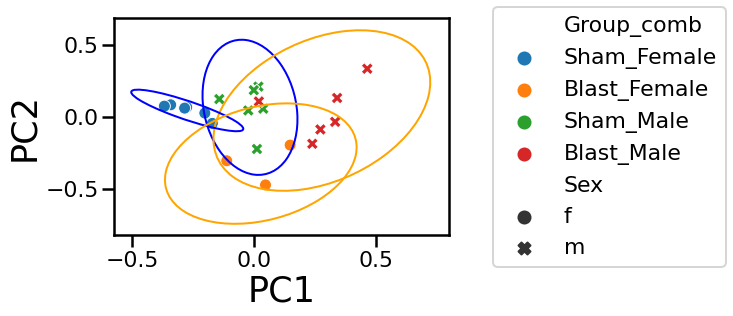

In [158]:
ax = sns.scatterplot(data=data_beta_final, x="PC1", y="PC2", hue='Group_comb', style="Sex")
plt.legend(bbox_to_anchor=(1.1, 1.1), bbox_transform=ax.transAxes)

data_beta_final_s = data_beta_final[data_beta_final['Group']=='Sham']
data_beta_final_b = data_beta_final[data_beta_final['Group']=='Blast']

data_beta_final_sm = data_beta_final_s[data_beta_final_s['Sex']=='m']
confidence_ellipse(x=data_beta_final_sm["PC1"], y=data_beta_final_sm["PC2"], ax=ax, edgecolor='blue')

data_beta_final_bm = data_beta_final_b[data_beta_final_b['Sex']=='m']
confidence_ellipse(x=data_beta_final_bm["PC1"], y=data_beta_final_bm["PC2"], ax=ax, edgecolor='orange')

data_beta_final_sf = data_beta_final_s[data_beta_final_s['Sex']=='f']
confidence_ellipse(x=data_beta_final_sf["PC1"], y=data_beta_final_sf["PC2"], ax=ax, edgecolor='blue')

data_beta_final_bf = data_beta_final_b[data_beta_final_b['Sex']=='f']
confidence_ellipse(x=data_beta_final_bf["PC1"], y=data_beta_final_bf["PC2"], ax=ax, edgecolor='orange')

plt.show()


In [159]:
sample_md = data_touse[['animal_code', 'Group_comb']].set_index(['animal_code'])

#determine if sig
anosim_stat = anosim(bc_dm, sample_md, column='Group_comb', permutations=500)
print(anosim_stat, '\n')
permanova_stat = permanova(bc_dm, sample_md, column='Group_comb', permutations=500)
print(permanova_stat)

method name                   ANOSIM
test statistic name                R
sample size                       21
number of groups                   4
test statistic              0.669239
p-value                   0.00199601
number of permutations           500
Name: ANOSIM results, dtype: object 

method name                PERMANOVA
test statistic name         pseudo-F
sample size                       21
number of groups                   4
test statistic               9.24842
p-value                   0.00199601
number of permutations           500
Name: PERMANOVA results, dtype: object


## Taxa level analysis and viz

#### phylum

In [160]:
#use file name to create path of files
data_phylum = pd.DataFrame()

for ship in ship_file_names:
    print(ship)
    
    path = make_path(ship, 'phylum')
    print(path)
    
    data_int = pd.read_table(path)
    data_int = pd.DataFrame(data = data_int).set_index('@tax_phylum_level').T.reset_index()
    
    data_int.rename(columns={"index": 'animal_code'}, inplace=True)
    data_int['animal_code'] = [str(x) for x in data_int['animal_code']]
    data_int['file_name'] = ship
    print(data_int.shape)
    
    if data_phylum.shape[0] == 0:
        data_phylum = data_int
    else:
        data_phylum = pd.concat([data_phylum, data_int])
    
    print(data_phylum.shape)

data_phylum.replace({np.nan: 0}, inplace=True)    
print(data_phylum.shape)
data_phylum.tail()


ship1_VNS4m_24h_72h
/Users/abbieschindler/Documents/Schindler_Lab/Data/Microbiome/data/SSS/ship1_VNS4m_24h_72h/report/data/filtered-tables/taxatables-by-level/taxatable-phylum-short-relative.tsv
(35, 9)
(35, 9)
ship2_VNS72h_norBNI72h_4m
/Users/abbieschindler/Documents/Schindler_Lab/Data/Microbiome/data/SSS/ship2_VNS72h_norBNI72h_4m/report/data/filtered-tables/taxatables-by-level/taxatable-phylum-short-relative.tsv
(58, 8)
(93, 9)
ship3_mf1d_CLAMS272h_etoh
/Users/abbieschindler/Documents/Schindler_Lab/Data/Microbiome/data/SSS/ship3_mf1d_CLAMS272h_etoh/report/data/filtered-tables/taxatables-by-level/taxatable-phylum-short-relative.tsv
(49, 8)
(142, 9)
(142, 9)


,animal_code,p__Actinobacteria,p__Bacteroidetes,p__Firmicutes,p__Fusobacteria,p__Other,p__Proteobacteria,p__Verrucomicrobia,file_name
44,874,0.000352,0.081537,0.712592,0.0,0.000165,0.001344,0.204011,ship3_mf1d_CLAMS272h_etoh
45,875,0.000390,0.006371,0.926102,0.0,0.000078,0.000293,0.066765,ship3_mf1d_CLAMS272h_etoh
46,997,0.127212,0.329998,0.405278,0.0,0.000871,0.010513,0.126128,ship3_mf1d_CLAMS272h_etoh
47,998,0.087672,0.139443,0.407054,0.0,0.000683,0.002814,0.362334,ship3_mf1d_CLAMS272h_etoh
48,999,0.028975,0.041315,0.558063,0.0,0.000369,0.002810,0.368468,ship3_mf1d_CLAMS272h_etoh


In [161]:
#combine with meta data
data_phylum_final = data_animal_meta.merge(data_phylum, 
                                          on=['animal_code', 'file_name'])

print(data_phylum_final.shape)
data_phylum_final.head()

(101, 59)


,Protocol,Round_summary,Round_main,Round_addl,file_name,Animal_#,animal_code,Notes,Cage_#,Group,Group_comb,Sex,feces_tp,feces_fs,Acute_OFB,Sac_TP,Treatment,PSI_1,PSI_2,PSI_3,PSI_ave,ms_1,ms_2,ms_3,ms_ave,imp_1,imp_2,imp_3,imp_ave,LORR_1,LORR_2,LORR_3,LORR_ave,wt_1,wt_2,wt_3,wt_24,wt_48,wt_72,wt_overnight,wt_24.1,wt_48.1,wt_72.1,Fibrinogen,Albumin,Delta,Distance,Mean speed,Center : entries,Center : time,Center : distance,Center : latency,p__Actinobacteria,p__Bacteroidetes,p__Firmicutes,p__Fusobacteria,p__Other,p__Proteobacteria,p__Verrucomicrobia
0,Schindler_male,biochemistry,bc_acute_r2,NaN,ship1_VNS4m_24h_72h,895,895.S,NaN,SA187,Sham,Sham_Male,m,1,s,n,1.0,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,32.0,32.1,32.5,31.8,NaN,NaN,0.312500,-0.625000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.197271,0.069069,0.625015,0.0,0.000115,0.004164,0.104365
1,Schindler_male,biochemistry,bc_acute_r2,NaN,ship1_VNS4m_24h_72h,896,896.S,NaN,SA187,Sham,Sham_Male,m,1,s,n,1.0,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,29.9,29.7,30.0,29.8,NaN,NaN,-0.668896,-0.334448,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.187045,0.189075,0.476721,0.0,0.000339,0.004067,0.142753
2,Schindler_male,biochemistry,bc_acute_r2,NaN,ship1_VNS4m_24h_72h,897,897.S,NaN,SA187,Sham,Sham_Male,m,1,s,n,1.0,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,28.8,28.8,29.0,29.1,NaN,NaN,0.000000,1.041667,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.324863,0.157521,0.470936,0.0,0.000183,0.002950,0.043547
3,Schindler_male,biochemistry,bc_acute_r2,NaN,ship1_VNS4m_24h_72h,898,898.S,NaN,SA188,Sham,Sham_Male,m,3,s,n,3.0,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,32.5,32.5,32.8,NaN,NaN,32.8,0.000000,NaN,NaN,0.923077,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.084920,0.053551,0.834566,0.0,0.000070,0.000970,0.025923
4,Schindler_male,biochemistry,bc_acute_r2,NaN,ship1_VNS4m_24h_72h,899,899.S,NaN,SA188,Sham,Sham_Male,m,3,s,n,3.0,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,30.5,30.2,30.4,NaN,NaN,29.6,-0.983607,NaN,NaN,-2.950820,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.050276,0.118822,0.755262,0.0,0.000442,0.001163,0.074036


In [162]:
#calculate ratios etc.
data_phylum_final['fb_ratio'] = data_phylum_final['p__Firmicutes'] / data_phylum_final['p__Bacteroidetes']
data_phylum_final['va_sum'] = data_phylum_final['p__Verrucomicrobia'] + data_phylum_final['p__Actinobacteria']

In [163]:
data_phylum = data_phylum_final[data_phylum_final['Round_main'] == 'bc_BBB_r1']
data_phylum

,Protocol,Round_summary,Round_main,Round_addl,file_name,Animal_#,animal_code,Notes,Cage_#,Group,Group_comb,Sex,feces_tp,feces_fs,Acute_OFB,Sac_TP,Treatment,PSI_1,PSI_2,PSI_3,PSI_ave,ms_1,ms_2,ms_3,ms_ave,imp_1,imp_2,imp_3,imp_ave,LORR_1,LORR_2,LORR_3,LORR_ave,wt_1,wt_2,wt_3,wt_24,wt_48,wt_72,wt_overnight,wt_24.1,wt_48.1,wt_72.1,Fibrinogen,Albumin,Delta,Distance,Mean speed,Center : entries,Center : time,Center : distance,Center : latency,p__Actinobacteria,p__Bacteroidetes,p__Firmicutes,p__Fusobacteria,p__Other,p__Proteobacteria,p__Verrucomicrobia,fb_ratio,va_sum
15,Schindler_female,SABV,bc_BBB_r1,NaN,ship3_mf1d_CLAMS272h_etoh,25,25,NaN,SA267,Sham,Sham_Female,f,1,f,2,3.0,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,19.8,19.1,19.3,NaN,19.9,NaN,-3.535354,NaN,0.505051,NaN,0.485228,0.369233,0.115995,25.434,0.085,10.0,17.4,3.109,33.1,0.081616,0.005081,0.865883,0.0,0.000044,9.083757e-06,0.047366,170.410559,0.128982
16,Schindler_female,SABV,bc_BBB_r1,NaN,ship3_mf1d_CLAMS272h_etoh,26,26,NaN,SA267,Sham,Sham_Female,f,1,f,2,3.0,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,20.4,20.2,20.3,NaN,19.6,NaN,-0.980392,NaN,-3.921569,NaN,0.833918,0.492179,0.341739,30.332,0.101,17.0,33.6,5.750,34.3,0.175135,0.015799,0.697955,0.0,0.000193,2.421841e-05,0.110893,44.177610,0.286028
17,Schindler_female,SABV,bc_BBB_r1,NaN,ship3_mf1d_CLAMS272h_etoh,27,27,NaN,SA267,Sham,Sham_Female,f,1,f,2,3.0,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,22.0,22.1,22.3,NaN,22.5,NaN,0.454545,NaN,2.272727,NaN,0.378310,0.244336,0.133974,40.104,0.134,19.0,25.9,5.816,15.0,0.057430,0.006109,0.877272,0.0,0.000181,4.536848e-05,0.058963,143.603204,0.116393
18,Schindler_female,SABV,bc_BBB_r1,NaN,ship3_mf1d_CLAMS272h_etoh,28,28,NaN,SA268,Sham,Sham_Female,f,1,f,2,3.0,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,20.4,20.4,19.5,NaN,19.6,NaN,0.000000,NaN,-3.921569,NaN,0.487847,0.445188,0.042660,27.350,0.091,20.0,31.8,6.601,28.7,0.103729,0.009917,0.839426,0.0,0.000073,2.007418e-05,0.046836,84.648168,0.150565
19,Schindler_female,SABV,bc_BBB_r1,NaN,ship3_mf1d_CLAMS272h_etoh,29,29,NaN,SA268,Sham,Sham_Female,f,1,f,2,3.0,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,21.4,21.5,20.6,NaN,20.7,NaN,0.467290,NaN,-3.271028,NaN,0.427856,0.359363,0.068493,30.264,0.101,21.0,56.5,7.110,0.0,0.109666,0.010786,0.692222,0.0,0.000034,3.854670e-06,0.187288,64.175824,0.296954
20,Schindler_female,SABV,bc_BBB_r1,NaN,ship3_mf1d_CLAMS272h_etoh,30,30,NaN,SA268,Sham,Sham_Female,f,1,f,2,3.0,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,21.7,21.8,21.7,NaN,21.9,NaN,0.460829,NaN,0.921659,NaN,NaN,NaN,NaN,49.752,0.166,21.0,19.9,5.796,11.1,0.057112,0.007953,0.866912,0.0,0.000160,5.059399e-05,0.067811,108.998175,0.124924
21,Schindler_female,SABV,bc_BBB_r1,NaN,ship3_mf1d_CLAMS272h_etoh,36,36,NaN,SA270,Blast,Blast_Female,f,1,f,2,3.0,2,18.74,17.94,18.69,18.456667,6.016,5.940,6.050,6.002000,0.040,0.040,0.040,0.040000,NaN,NaN,NaN,NaN,23.6,22.2,21.0,NaN,21.9,NaN,-5.932203,NaN,-7.203390,NaN,0.573544,0.472185,0.101359,9.193,0.031,2.0,3.0,0.317,89.8,0.074577,0.068006,0.374244,0.0,0.000433,5.443077e-05,0.482686,5.503060,0.557262
22,Schindler_female,SABV,bc_BBB_r1,NaN,ship3_mf1d_CLAMS272h_etoh,37,37,NaN,SA271,Blast,Blast_Female,f,1,f,2,3.0,2,18.34,17.69,19.56,18.530000,5.940,5.190,6.170,5.766667,0.039,0.040,0.040,0.039667,NaN,NaN,NaN,NaN,20.3,18.3,18.6,NaN,19.9,NaN,-9.852217,NaN,-1.970443,NaN,0.759904,0.503839,0.256065,9.908,0.033,10.0,26.2,1.688,92.7,0.142722,0.016419,0.539078,0.0,0.000083,2.050211e-05,0.301678,32.833444,0.444399
23,Schindler_female,SABV,bc_BBB_r1,NaN,ship3_mf1d_CLAMS272h_etoh,39,39,NaN,SA271,Blast,Blast_Female,f,1,f,2,3.0,2,19.74,19.77,19.43,19.646667,5.937,5.938,5.938,5.937667,0.039,0.039,0.039,0.039000,NaN,NaN,NaN,NaN,16.9,15.4,14.4,NaN,15.3,NaN,-8.875740,NaN,-9.467456,NaN,1.068564,0.403377,0.665188,26.956,0.090,6.0,10.5,1.844,62.4,0.074781,0.002672,0.486650,0.0,0.000026,7.856282e-07,0.435871,182

p__Actinobacteria


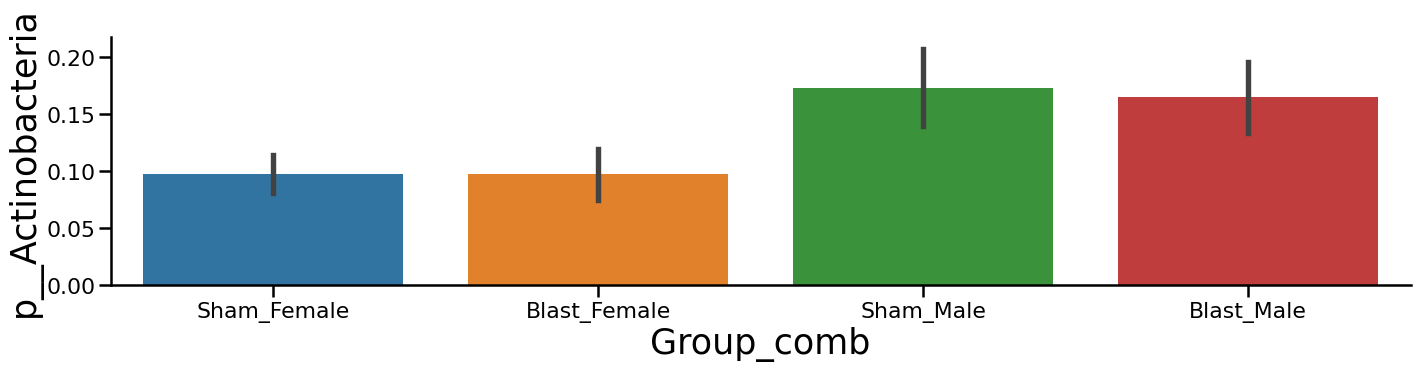





p__Bacteroidetes


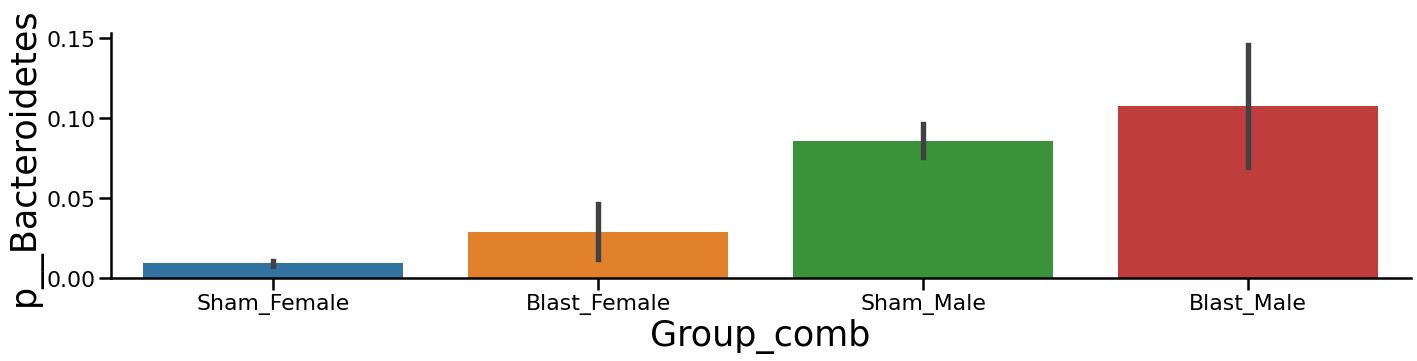





p__Firmicutes


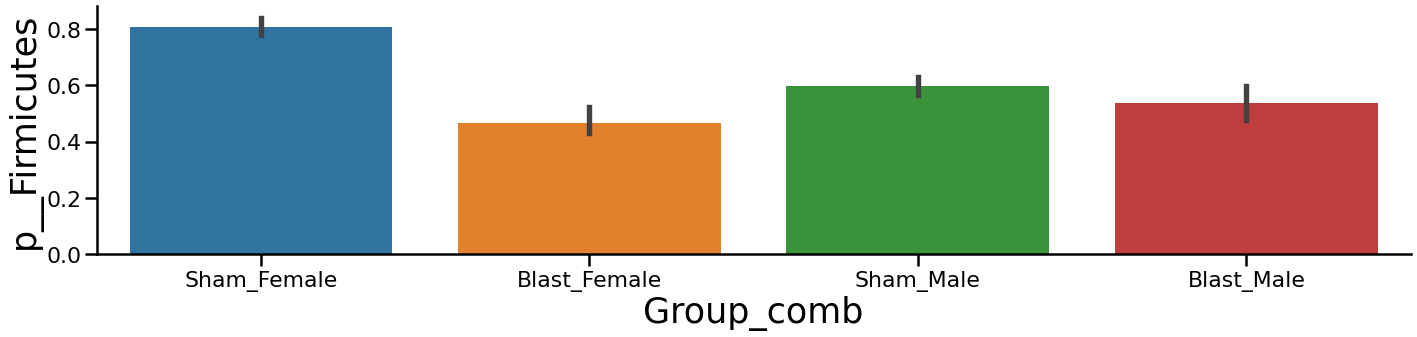





p__Fusobacteria


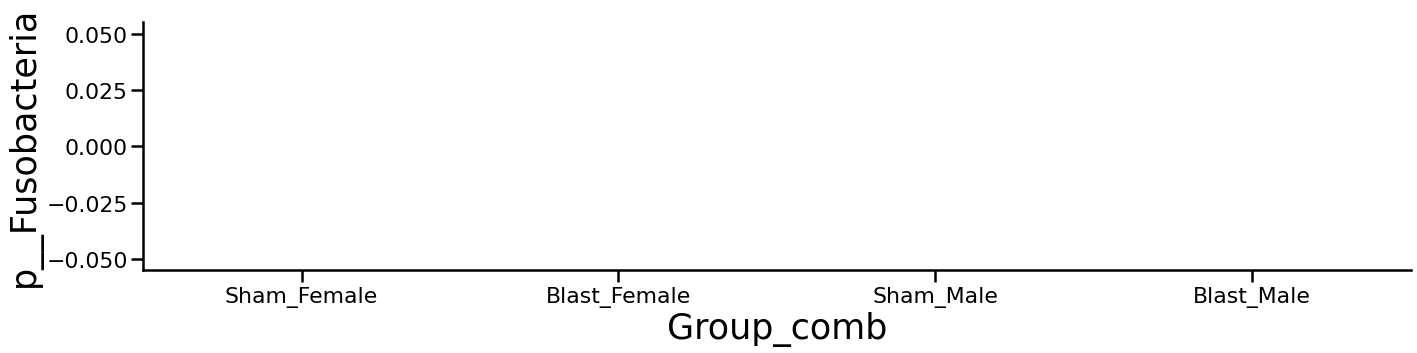





p__Other


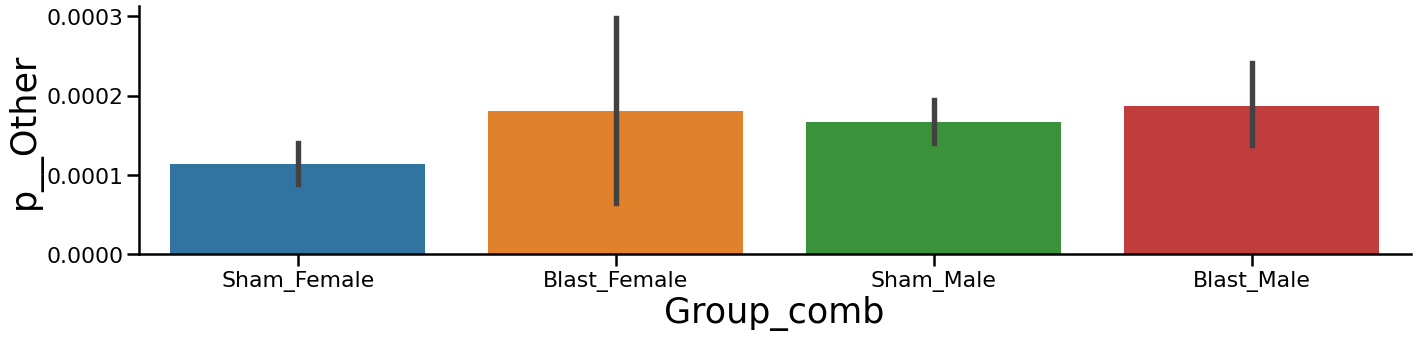





p__Proteobacteria


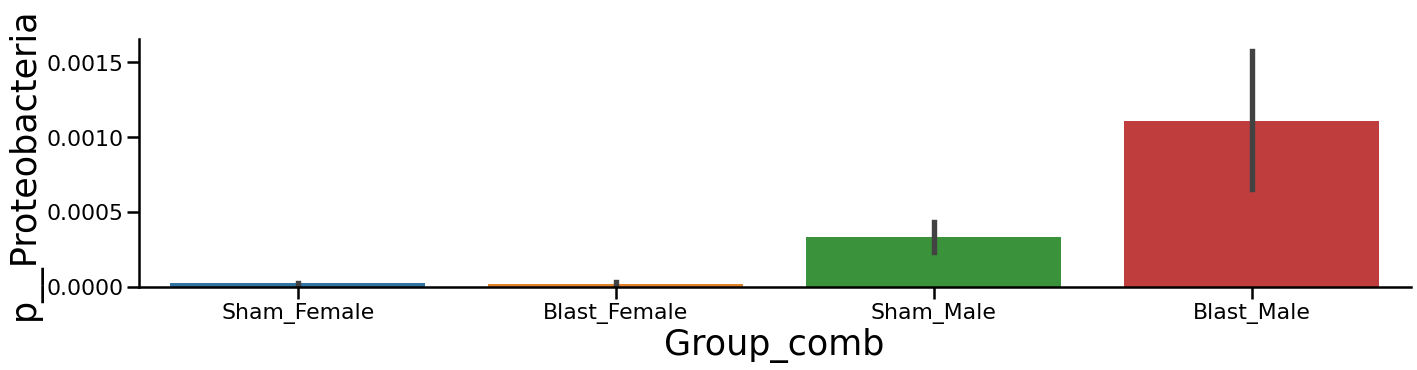





p__Verrucomicrobia


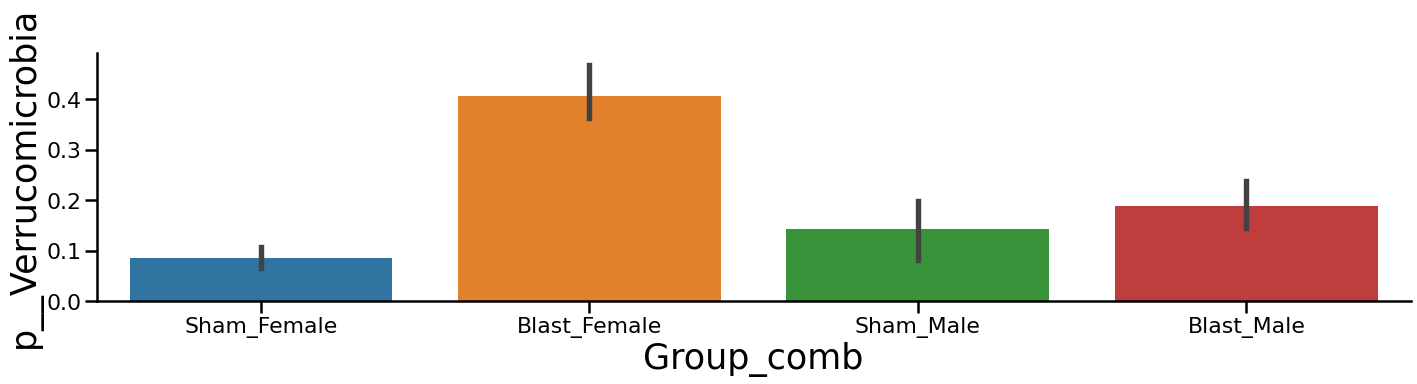





fb_ratio


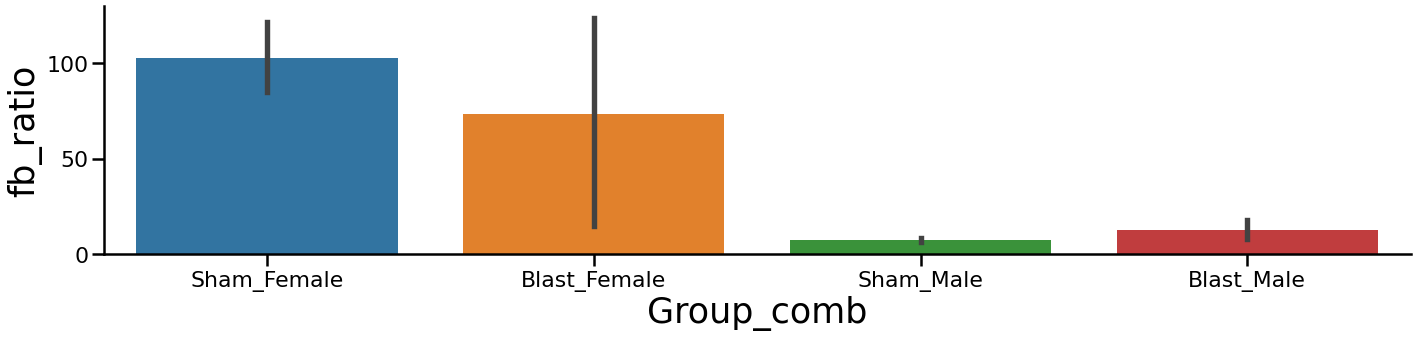





va_sum


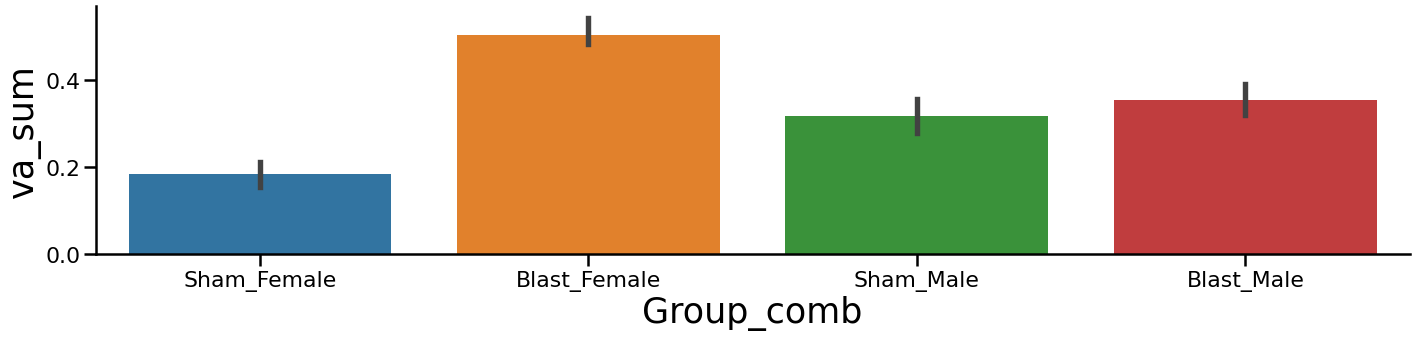

In [164]:
#determine potential significance 
params = ['p__Actinobacteria', 'p__Bacteroidetes', 'p__Firmicutes', 
          'p__Fusobacteria', 'p__Other', 'p__Proteobacteria', 'p__Verrucomicrobia', 
          'fb_ratio', 'va_sum']

for param in params:
    try:
        print(param)

        g = sns.catplot(x='Group_comb', y=param, data=data_phylum, kind='bar', height=5, aspect=4, ci=68)
        plt.show()
        print('\n')
        
        #x = OTU_data_diversity[OTU_data_diversity['group'] == 4][param]
        #y = OTU_data_diversity[OTU_data_diversity['group'] == 5][param]
        #z = OTU_data_diversity[OTU_data_diversity['group'] == 7][param]
        #print(stats.kruskal(y, z))
        print('\n')
        
    except:
        pass

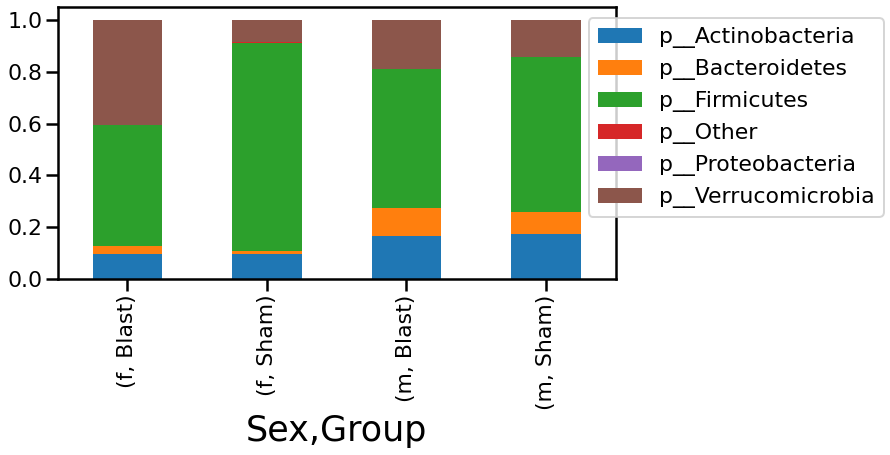

In [165]:
data_phylum[['Group', 'Sex', 'p__Actinobacteria', 'p__Bacteroidetes', 'p__Firmicutes', 
          'p__Other', 'p__Proteobacteria', 'p__Verrucomicrobia']].groupby(['Sex', 'Group']).mean().plot(kind='bar', stacked=True, figsize=(10,5))
plt.legend(loc='upper right', bbox_to_anchor=(1.5, 1.))
plt.show()

## Corr and cluster viz

In [166]:
data_phylum['observed'] = data_alpha['observed'].values
data_phylum['chao1'] = data_alpha['chao1'].values
data_phylum['shannon'] = data_alpha['shannon'].values

data_phylum['PC1'] = data_beta_final['PC1'].values
data_phylum['PC2'] = data_beta_final['PC2'].values

print(data_phylum.columns.values)
data_phylum

['Protocol' 'Round_summary' 'Round_main' 'Round_addl' 'file_name'
 'Animal_#' 'animal_code' 'Notes' 'Cage_#' 'Group' 'Group_comb' 'Sex'
 'feces_tp' 'feces_fs' 'Acute_OFB' 'Sac_TP' 'Treatment' 'PSI_1' 'PSI_2'
 'PSI_3' 'PSI_ave' 'ms_1' 'ms_2' 'ms_3' 'ms_ave' 'imp_1' 'imp_2' 'imp_3'
 'imp_ave' 'LORR_1' 'LORR_2' 'LORR_3' 'LORR_ave' 'wt_1' 'wt_2' 'wt_3'
 'wt_24' 'wt_48' 'wt_72' 'wt_overnight' 'wt_24.1' 'wt_48.1' 'wt_72.1'
 'Fibrinogen' 'Albumin' 'Delta' 'Distance' 'Mean speed' 'Center : entries'
 'Center : time' 'Center : distance' 'Center : latency'
 'p__Actinobacteria' 'p__Bacteroidetes' 'p__Firmicutes' 'p__Fusobacteria'
 'p__Other' 'p__Proteobacteria' 'p__Verrucomicrobia' 'fb_ratio' 'va_sum'
 'observed' 'chao1' 'shannon' 'PC1' 'PC2']


,Protocol,Round_summary,Round_main,Round_addl,file_name,Animal_#,animal_code,Notes,Cage_#,Group,Group_comb,Sex,feces_tp,feces_fs,Acute_OFB,Sac_TP,Treatment,PSI_1,PSI_2,PSI_3,PSI_ave,ms_1,ms_2,ms_3,ms_ave,imp_1,imp_2,imp_3,imp_ave,LORR_1,LORR_2,LORR_3,LORR_ave,wt_1,wt_2,wt_3,wt_24,wt_48,wt_72,wt_overnight,wt_24.1,wt_48.1,wt_72.1,Fibrinogen,Albumin,Delta,Distance,Mean speed,Center : entries,Center : time,Center : distance,Center : latency,p__Actinobacteria,p__Bacteroidetes,p__Firmicutes,p__Fusobacteria,p__Other,p__Proteobacteria,p__Verrucomicrobia,fb_ratio,va_sum,observed,chao1,shannon,PC1,PC2
15,Schindler_female,SABV,bc_BBB_r1,NaN,ship3_mf1d_CLAMS272h_etoh,25,25,NaN,SA267,Sham,Sham_Female,f,1,f,2,3.0,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,19.8,19.1,19.3,NaN,19.9,NaN,-3.535354,NaN,0.505051,NaN,0.485228,0.369233,0.115995,25.434,0.085,10.0,17.4,3.109,33.1,0.081616,0.005081,0.865883,0.0,0.000044,9.083757e-06,0.047366,170.410559,0.128982,75.0,125.750000,1.625063,-0.341532,0.085601
16,Schindler_female,SABV,bc_BBB_r1,NaN,ship3_mf1d_CLAMS272h_etoh,26,26,NaN,SA267,Sham,Sham_Female,f,1,f,2,3.0,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,20.4,20.2,20.3,NaN,19.6,NaN,-0.980392,NaN,-3.921569,NaN,0.833918,0.492179,0.341739,30.332,0.101,17.0,33.6,5.750,34.3,0.175135,0.015799,0.697955,0.0,0.000193,2.421841e-05,0.110893,44.177610,0.286028,116.0,159.333333,2.901467,-0.201794,0.028548
17,Schindler_female,SABV,bc_BBB_r1,NaN,ship3_mf1d_CLAMS272h_etoh,27,27,NaN,SA267,Sham,Sham_Female,f,1,f,2,3.0,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,22.0,22.1,22.3,NaN,22.5,NaN,0.454545,NaN,2.272727,NaN,0.378310,0.244336,0.133974,40.104,0.134,19.0,25.9,5.816,15.0,0.057430,0.006109,0.877272,0.0,0.000181,4.536848e-05,0.058963,143.603204,0.116393,90.0,135.090909,2.245945,-0.276006,0.068946
18,Schindler_female,SABV,bc_BBB_r1,NaN,ship3_mf1d_CLAMS272h_etoh,28,28,NaN,SA268,Sham,Sham_Female,f,1,f,2,3.0,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,20.4,20.4,19.5,NaN,19.6,NaN,0.000000,NaN,-3.921569,NaN,0.487847,0.445188,0.042660,27.350,0.091,20.0,31.8,6.601,28.7,0.103729,0.009917,0.839426,0.0,0.000073,2.007418e-05,0.046836,84.648168,0.150565,70.0,81.400000,1.525898,-0.367457,0.076347
19,Schindler_female,SABV,bc_BBB_r1,NaN,ship3_mf1d_CLAMS272h_etoh,29,29,NaN,SA268,Sham,Sham_Female,f,1,f,2,3.0,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,21.4,21.5,20.6,NaN,20.7,NaN,0.467290,NaN,-3.271028,NaN,0.427856,0.359363,0.068493,30.264,0.101,21.0,56.5,7.110,0.0,0.109666,0.010786,0.692222,0.0,0.000034,3.854670e-06,0.187288,64.175824,0.296954,82.0,132.142857,2.479867,-0.171104,-0.042949
20,Schindler_female,SABV,bc_BBB_r1,NaN,ship3_mf1d_CLAMS272h_etoh,30,30,NaN,SA268,Sham,Sham_Female,f,1,f,2,3.0,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,21.7,21.8,21.7,NaN,21.9,NaN,0.460829,NaN,0.921659,NaN,NaN,NaN,NaN,49.752,0.166,21.0,19.9,5.796,11.1,0.057112,0.007953,0.866912,0.0,0.000160,5.059399e-05,0.067811,108.998175,0.124924,95.0,149.076923,2.068196,-0.284463,0.062609
21,Schindler_female,SABV,bc_BBB_r1,NaN,ship3_mf1d_CLAMS272h_etoh,36,36,NaN,SA270,Blast,Blast_Female,f,1,f,2,3.0,2,18.74,17.94,18.69,18.456667,6.016,5.940,6.050,6.002000,0.040,0.040,0.040,0.040000,NaN,NaN,NaN,NaN,23.6,22.2,21.0,NaN,21.9,NaN,-5.932203,NaN,-7.203390,NaN,0.573544,0.472185,0.101359,9.193,0.031,2.0,3.0,0.317,89.8,0.074577,0.068006,0.374244,0.0,0.000433,5.443077e-05,0.482686,5.503060,0.557262,144.0,195.130435,3.402675,0.046448,-0.468918
22,Schindler_female,SABV,bc_BBB_r1,NaN,ship3_mf1d_CLAMS272h_etoh,37,37,NaN,SA271,Blast,Blast_Female,f,1,f,2,3.0,2,18.34,17.69,19.56,18.530000,5.940,5.190,6.170,5.766667,0.039,0.040,0.040,0.039667,NaN,NaN,NaN,NaN,20.3,18.3,18.6,NaN,19.9,NaN,-9.852217,NaN,-1.970443,NaN,0.759904,0.503839,0.256065,9.908,0.033,10.0,26.2,1.688,92.7,0.142722,0.016419,0.539078,0.0,0.000083,2.050211e-05,0.301678,32.833444,0.444399,106.0,128.235294,3.383292,0.147301,-0.193157
23,Schi

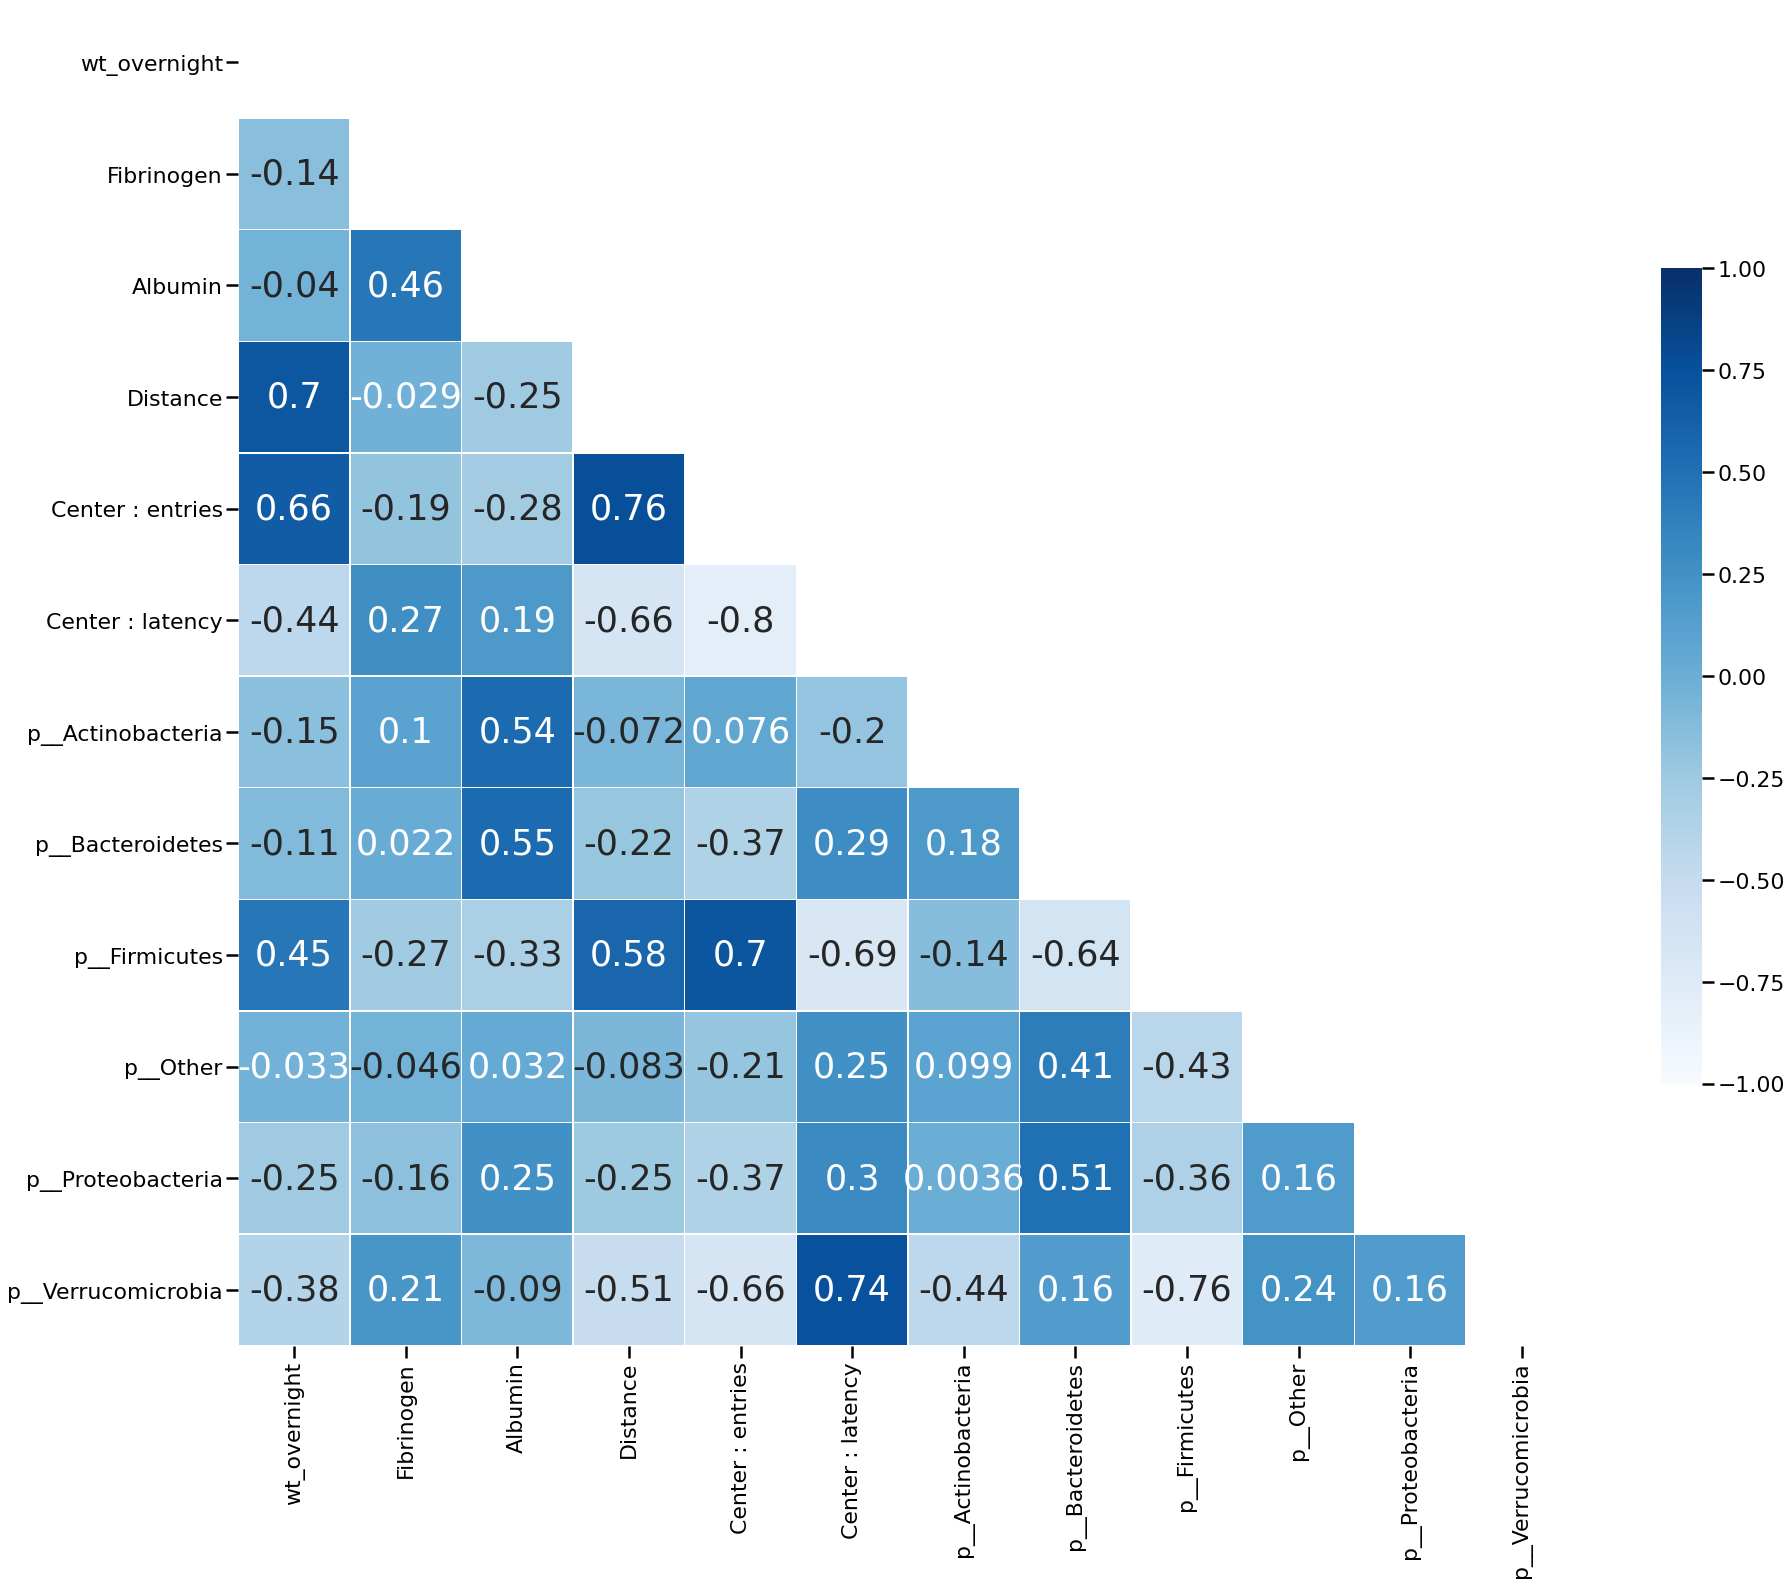

In [174]:
params = ['wt_overnight', 'Fibrinogen', 'Albumin', 
          'Distance', 'Center : entries', 'Center : latency', 
          'p__Actinobacteria', 'p__Bacteroidetes', 'p__Firmicutes',
          'p__Other', 'p__Proteobacteria', 'p__Verrucomicrobia', ]

fig, ax = plt.subplots(figsize=(30,30))
corr = data_phylum[params].corr()
mask = np.triu(np.ones_like(corr, dtype=bool))
ax = sns.heatmap(corr, annot=True, vmin=-1, vmax=1, center=0, cmap = 'Blues', mask=mask,
                square=True, linewidths=.5, cbar_kws={"shrink": .5})
plt.xticks(rotation = 90)
plt.yticks(rotation = 0)
plt.show()

In [113]:
data_phylum['Group_comb'].unique()

array(['Sham_Female', 'Blast_Female', 'Sham_Male', 'Blast_Male'],
      dtype=object)

<Figure size 1080x1080 with 0 Axes>

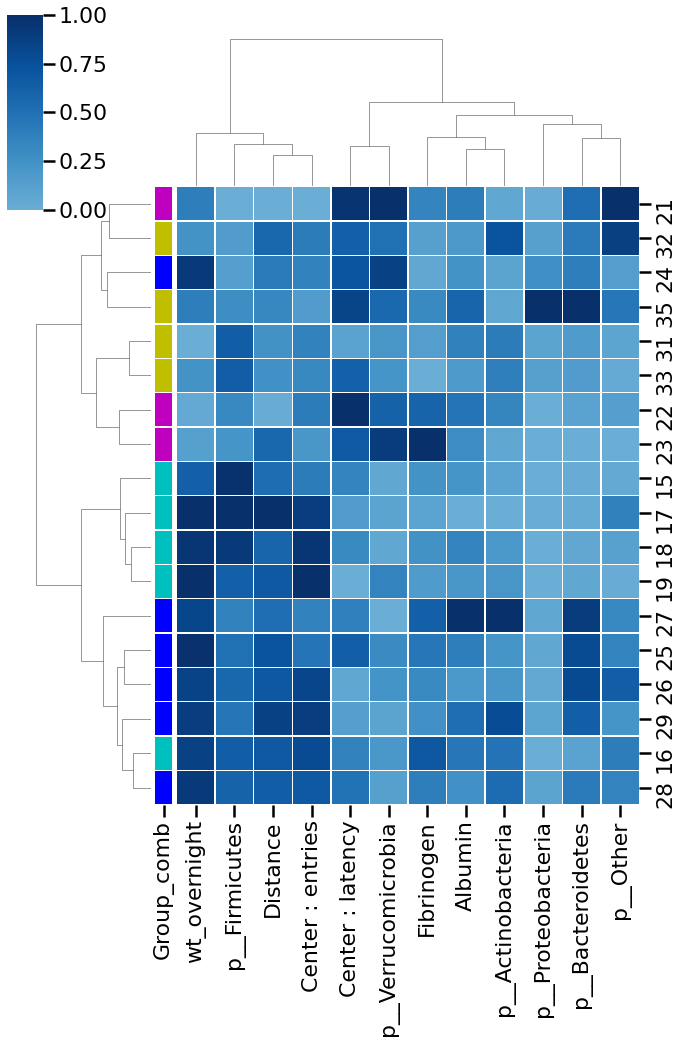

In [172]:
sns.color_palette("flare", as_cmap=True)
params = ['wt_overnight', 'Fibrinogen', 'Albumin', 
          'Distance', 'Center : entries', 'Center : latency', 
          'p__Actinobacteria', 'p__Bacteroidetes', 'p__Firmicutes',
          'p__Other', 'p__Proteobacteria', 'p__Verrucomicrobia']

lut = dict(zip(data_phylum['Group_comb'].unique(), "cmby"))
row_colors = data_phylum['Group_comb'].map(lut)
plt.figure(figsize=(15,15))

g = sns.clustermap(data_phylum[params].dropna(axis=0), row_colors=row_colors,
                 metric="euclidean", standard_scale=1, method="ward",
               vmin=0, vmax=1, center=0, cmap = 'Blues', 
               square=True, linewidths=.5, cbar_kws={"shrink": .5}, figsize=(10,15))
plt.show()